In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [244]:
Diff = L.Lambda(lambda x: tf.gradients(x[0], x[1])[0])
Norm = L.Lambda(lambda x: tf.norm(x, axis=-1))
Div = L.Lambda(lambda x: tf.divide(x[0], x[1] + 1e-16))
Dot = L.Dot(axes=[-1, -1])
relu = tf.keras.backend.relu
summ = tf.keras.backend.sum
Sum = L.Lambda(lambda x: summ(x, axis=-1, keepdims=True))
Norm2 = L.Lambda(lambda x: summ(tf.square(x), axis=-1, keepdims=True))

phi0 = L.Lambda(lambda x: tf.sqrt(tf.abs(x[0] - x[1])))
phi1 = L.Lambda(lambda x: tf.abs(x[0] - x[1]))
phi2 = L.Lambda(lambda x: tf.square(x[0] - x[1]))

def NNEikonal(nl=3, nu=50, act='tanh', dim=1, phi=phi2,
              outputs=None, models=None, autoPR=True, factored=False):
    
    if outputs is None:
        if autoPR:
            outputs = ['Er', 'Es', 'Mr', 'Ms', 'H', 'S']
        else:
            outputs = ['Er', 'Es', 'Mr', 'Ms', 'H', 'S', 'P', 'R']
    if models is None:
        models = ['T'] + outputs + ['Gr', 'Gs']
        
    xs = L.Input(shape=(dim,), name='xs')
    xr = L.Input(shape=(dim,), name='xr')
    inputs = [xs, xr]
    # Input combinations
    xsr = [xs, xr]; xrs = [xr, xs]
    xss = [xs, xs]; xrr = [xr, xr]
    
    xr_xs = L.Subtract()([xr, xs])
    xs_xr = L.Subtract()([xs, xr])
    d = Norm(xr_xs)
    p = L.Lambda(lambda x: x / 2)(xr_xs)
#     p = L.Lambda(lambda x: tf.random.uniform((dim,)))(None)
    xsp = [xs, p]
    xpr = [p, xr]
    
    # Trainable body
    x = L.Concatenate()(inputs)
    y = x
    for i in range(nl - 1):
        y = L.Dense(nu, activation=act)(y)
    
    # Traveltime
    T = L.Dense(1, name='t', activation='linear')(y)
    
    if autoPR:
        t = Model(inputs=inputs, outputs=T)
        phi_1 = phi([t(xsr), t(xrr)])
        phi_2 = phi([t(xrs), t(xss)])
        T = L.Add(name='Traveltime')([phi_1, phi_2])
    if factored:
        T = L.Multiply(name='Factored')([T, d])
    Tm = Model(inputs=inputs, outputs=T)
    
    # Positivity
    P = L.Lambda(lambda x: relu(-x), name='Positivity')(T)
    Pm = Model(inputs=inputs, outputs=P)
    
    # Reciprocity
    R = L.Subtract(name='Reciprocity')([Tm(xsr), Tm(xrs)])
    Rm = Model(inputs=inputs, outputs=R)
    
    # Hinge loss (triangle inequality)
    H = L.Lambda(lambda x: relu(x[0] - x[1] - x[2]), name='Hinge')([Tm(xsr), Tm(xsp), Tm(xpr)])
    Hm = Model(inputs=inputs, outputs=H)
    
    # Monotonicity over 'xr'
    dTr = Diff([T, xr])
    Gr = Model(inputs=inputs, outputs=dTr)
    Mr = Dot([dTr, xr_xs])
    if dim > 1:
        Mr = Div([Mr, Norm(dTr)])
        Mr = Div([Mr, Norm(xr_xs)])
    Mr = L.Lambda(lambda x: relu(-x), name='Monotonicity_xr')(Mr)
    Mmr = Model(inputs=inputs, outputs=Mr)
    
    # Monotonicity over 'xs'
    dTs = Diff([T, xs])
    Gs = Model(inputs=inputs, outputs=dTs)
    Ms = Dot([dTs, xs_xr])
    if dim > 1:
        Ms = Div([Ms, Norm(dTs)])
        Ms = Div([Ms, Norm(xs_xr)])
    Ms = L.Lambda(lambda x: relu(-x), name='Monotonicity_xs')(Ms)
    Mms = Model(inputs=inputs, outputs=Ms)
    
    # Eikonal over 'xr'
    Enr = Norm2(dTr)
    Er = L.Lambda(lambda x: tf.sqrt(x), name='Eikonal_xr')(Enr)
    Emr = Model(inputs=inputs, outputs=Er)
    
    # Eikonal over 'xs'
    Ens = Norm2(dTs)
    Es = L.Lambda(lambda x: tf.sqrt(x), name='Eikonal_xs')(Ens)
    Ems = Model(inputs=inputs, outputs=Es)
    
    # Mixed derivative 
    d2Trs = Diff([Enr, xs])
    S = L.Lambda(lambda x: tf.norm(x, axis=-1), name='Mixed')(d2Trs)
    Sm = Model(inputs=inputs, outputs=S)
    
    # Trainable model
    kw_models = dict(T=Tm, Er=Emr, Es=Ems, Mr=Mmr, Ms=Mms, 
                     Gr=Gr, Gs=Gs, H=Hm, S=Sm, P=Pm, R=Rm)
    kw_outs = dict(T=T, Er=Er, Es=Es, Mr=Mr, Ms=Ms, 
                   H=H, S=S, P=P, R=R)
    outs = [kw_outs[kw] for kw in outputs]
    
    model = Model(inputs=inputs, outputs=outs)
    out_models = {kw:kw_models[kw] for kw in models}
    
    return model, out_models

# 1D case

In [78]:
model, outs = NNEikonal(act='tanh')

In [74]:
nx = 51

w = np.ones((nx, nx)) - np.eye(nx)
ids = w==1

x = np.linspace(0, 100, nx)
v = np.linspace(0.5, 1.0, nx)
a, b = np.abs((v[-1] - v[0]) / (x[-1] - x[0])), 0.5

Vxr = np.repeat(v[None, ...], nx, axis=0)
Vxr_tr = Vxr[ids]
Vxs = np.repeat(v[..., None], nx, axis=1)
Vxs_tr = Vxs[ids]

X = np.meshgrid(x, x, indexing='ij')
x_test = dict(xs = X[0].ravel(), xr = X[1].ravel())
x_train = dict(xs = X[0][ids], xr = X[1][ids])
y_true = np.zeros_like(X[0][ids])

T = np.abs(np.log(np.abs((a * x[None, ...] + b) /  (a * x[..., None] + b)))) / a

In [82]:
adam = tf.optimizers.Adam(learning_rate=8e-3, decay=1e-3)
model.compile(optimizer=adam, loss='mae', 
              loss_weights=None)

In [83]:
h = model.fit(x=x_train, y=[1/Vxr_tr, 1/Vxs_tr]+[y_true]*6, 
              batch_size=800, 
              epochs=10000,
              sample_weight=None,
              verbose=1)

Epoch 1/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4915 - Eikonal_xr_loss: 1.3141 - Eikonal_xs_loss: 1.3140 - Monotonicity_xr_loss: 0.0056 - Monotonicity_xs_loss: 7.0818e-04 - Hinge_loss: 0.0126 - Mixed_loss: 0.0017 - Positivity_loss: 8.3937e-06 - Reciprocity_loss: 0.8428    
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6653 - Eikonal_xr_loss: 1.3231 - Eikonal_xs_loss: 1.3273 - Monotonicity_xr_loss: 0.0011 - Monotonicity_xs_loss: 8.2424e-06 - Hinge_loss: 0.0279 - Mixed_loss: 0.0015 - Positivity_loss: 0.0021 - Reciprocity_loss: 0.9823    
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2930 - Eikonal_xr_loss: 1.3417 - Eikonal_xs_loss: 1.3330 - Monotonicity_xr_loss: 0.0017 - Monotonicity_xs_loss: 4.5831e-04 - Hinge_loss: 7.8479e-05 - Mixed_loss: 7.6875e-04 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.6153
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9435 - Eikonal_xr_loss

4/4 [==============================] - 0s 8ms/step - loss: 2.6840 - Eikonal_xr_loss: 1.3295 - Eikonal_xs_loss: 1.3256 - Monotonicity_xr_loss: 1.8248e-04 - Monotonicity_xs_loss: 1.4408e-04 - Hinge_loss: 1.4593e-04 - Mixed_loss: 0.0011 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0274
Epoch 27/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6910 - Eikonal_xr_loss: 1.3271 - Eikonal_xs_loss: 1.3227 - Monotonicity_xr_loss: 5.1880e-04 - Monotonicity_xs_loss: 1.3980e-04 - Hinge_loss: 1.5555e-04 - Mixed_loss: 0.0012 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0391
Epoch 28/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6857 - Eikonal_xr_loss: 1.3242 - Eikonal_xs_loss: 1.3187 - Monotonicity_xr_loss: 1.7425e-04 - Monotonicity_xs_loss: 1.4784e-04 - Hinge_loss: 4.5865e-04 - Mixed_loss: 0.0013 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0407
Epoch 29/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6899 - Eikonal_xr_los

4/4 [==============================] - 0s 9ms/step - loss: 2.5796 - Eikonal_xr_loss: 1.2582 - Eikonal_xs_loss: 1.2547 - Monotonicity_xr_loss: 5.7262e-06 - Monotonicity_xs_loss: 2.2111e-04 - Hinge_loss: 3.1238e-04 - Mixed_loss: 0.0057 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0605
Epoch 53/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5575 - Eikonal_xr_loss: 1.2556 - Eikonal_xs_loss: 1.2513 - Monotonicity_xr_loss: 3.3098e-05 - Monotonicity_xs_loss: 1.0305e-04 - Hinge_loss: 2.6193e-04 - Mixed_loss: 0.0059 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0443
Epoch 54/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5694 - Eikonal_xr_loss: 1.2522 - Eikonal_xs_loss: 1.2494 - Monotonicity_xr_loss: 4.9812e-06 - Monotonicity_xs_loss: 2.2405e-04 - Hinge_loss: 2.6529e-05 - Mixed_loss: 0.0064 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0612
Epoch 55/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5788 - Eikonal_xr_lo

4/4 [==============================] - 0s 9ms/step - loss: 2.5237 - Eikonal_xr_loss: 1.1880 - Eikonal_xs_loss: 1.1896 - Monotonicity_xr_loss: 1.0656e-05 - Monotonicity_xs_loss: 4.9848e-06 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0163 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1299
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5535 - Eikonal_xr_loss: 1.1865 - Eikonal_xs_loss: 1.1862 - Monotonicity_xr_loss: 8.7455e-06 - Monotonicity_xs_loss: 3.5038e-06 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0167 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1640
Epoch 80/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5043 - Eikonal_xr_loss: 1.1816 - Eikonal_xs_loss: 1.1810 - Monotonicity_xr_loss: 3.8548e-04 - Monotonicity_xs_loss: 2.9887e-05 - Hinge_loss: 9.0398e-05 - Mixed_loss: 0.0173 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1239
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5386 - Eikonal_xr_lo

4/4 [==============================] - 0s 9ms/step - loss: 2.4255 - Eikonal_xr_loss: 1.1483 - Eikonal_xs_loss: 1.1476 - Monotonicity_xr_loss: 2.9105e-04 - Monotonicity_xs_loss: 9.1742e-04 - Hinge_loss: 0.0032 - Mixed_loss: 0.0248 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1003
Epoch 105/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4043 - Eikonal_xr_loss: 1.1458 - Eikonal_xs_loss: 1.1455 - Monotonicity_xr_loss: 1.0213e-04 - Monotonicity_xs_loss: 3.3307e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0262 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0862
Epoch 106/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3793 - Eikonal_xr_loss: 1.1283 - Eikonal_xs_loss: 1.1295 - Monotonicity_xr_loss: 1.7195e-04 - Monotonicity_xs_loss: 1.8953e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0294 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0918
Epoch 107/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4037 - Eikonal_xr_loss

4/4 [==============================] - 0s 9ms/step - loss: 2.4536 - Eikonal_xr_loss: 1.0775 - Eikonal_xs_loss: 1.0759 - Monotonicity_xr_loss: 4.8953e-06 - Monotonicity_xs_loss: 5.2670e-04 - Hinge_loss: 3.6392e-05 - Mixed_loss: 0.0299 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2698
Epoch 131/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4533 - Eikonal_xr_loss: 1.0879 - Eikonal_xs_loss: 1.0925 - Monotonicity_xr_loss: 2.3564e-05 - Monotonicity_xs_loss: 1.7232e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0290 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2438
Epoch 132/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4376 - Eikonal_xr_loss: 1.0837 - Eikonal_xs_loss: 1.0824 - Monotonicity_xr_loss: 2.8022e-04 - Monotonicity_xs_loss: 1.6996e-05 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0297 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2416
Epoch 133/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4016 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 2.2746 - Eikonal_xr_loss: 0.9916 - Eikonal_xs_loss: 0.9911 - Monotonicity_xr_loss: 4.1161e-05 - Monotonicity_xs_loss: 1.2533e-06 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0394 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2525
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2700 - Eikonal_xr_loss: 0.9870 - Eikonal_xs_loss: 0.9873 - Monotonicity_xr_loss: 4.2224e-06 - Monotonicity_xs_loss: 1.0403e-06 - Hinge_loss: 5.2918e-04 - Mixed_loss: 0.0381 - Positivity_loss: 2.3301e-06 - Reciprocity_loss: 0.2570
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2321 - Eikonal_xr_loss: 0.9855 - Eikonal_xs_loss: 0.9855 - Monotonicity_xr_loss: 4.4995e-05 - Monotonicity_xs_loss: 4.3743e-07 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0380 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2231
Epoch 159/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1622 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 2.1969 - Eikonal_xr_loss: 0.9224 - Eikonal_xs_loss: 0.9233 - Monotonicity_xr_loss: 2.6484e-04 - Monotonicity_xs_loss: 4.0586e-09 - Hinge_loss: 2.4121e-04 - Mixed_loss: 0.0453 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3054
Epoch 183/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1948 - Eikonal_xr_loss: 0.9169 - Eikonal_xs_loss: 0.9158 - Monotonicity_xr_loss: 4.4340e-08 - Monotonicity_xs_loss: 6.5495e-09 - Hinge_loss: 1.8350e-04 - Mixed_loss: 0.0438 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3181
Epoch 184/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2073 - Eikonal_xr_loss: 0.9098 - Eikonal_xs_loss: 0.9107 - Monotonicity_xr_loss: 4.1451e-06 - Monotonicity_xs_loss: 3.8159e-09 - Hinge_loss: 0.0023 - Mixed_loss: 0.0454 - Positivity_loss: 7.2519e-04 - Reciprocity_loss: 0.3383
Epoch 185/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2686 - Eikonal_xr_loss

4/4 [==============================] - 0s 10ms/step - loss: 1.9211 - Eikonal_xr_loss: 0.8480 - Eikonal_xs_loss: 0.8471 - Monotonicity_xr_loss: 1.4742e-07 - Monotonicity_xs_loss: 1.7927e-04 - Hinge_loss: 0.0022 - Mixed_loss: 0.0496 - Positivity_loss: 0.0049 - Reciprocity_loss: 0.1689
Epoch 209/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9188 - Eikonal_xr_loss: 0.8497 - Eikonal_xs_loss: 0.8531 - Monotonicity_xr_loss: 4.7829e-05 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0513 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1647
Epoch 210/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9487 - Eikonal_xr_loss: 0.8481 - Eikonal_xs_loss: 0.8490 - Monotonicity_xr_loss: 2.3010e-05 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0013 - Mixed_loss: 0.0507 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1997
Epoch 211/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9607 - Eikonal_xr_loss: 0.84

4/4 [==============================] - 0s 8ms/step - loss: 1.7953 - Eikonal_xr_loss: 0.7690 - Eikonal_xs_loss: 0.7693 - Monotonicity_xr_loss: 3.6062e-04 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.9884e-05 - Mixed_loss: 0.0603 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1962
Epoch 235/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8510 - Eikonal_xr_loss: 0.7625 - Eikonal_xs_loss: 0.7642 - Monotonicity_xr_loss: 7.6098e-06 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.0703e-04 - Mixed_loss: 0.0604 - Positivity_loss: 3.6495e-04 - Reciprocity_loss: 0.2628
Epoch 236/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9205 - Eikonal_xr_loss: 0.7584 - Eikonal_xs_loss: 0.7600 - Monotonicity_xr_loss: 1.9352e-05 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.0316e-04 - Mixed_loss: 0.0611 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3408
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8557 - Eikonal_xr

4/4 [==============================] - 0s 9ms/step - loss: 1.9766 - Eikonal_xr_loss: 0.7007 - Eikonal_xs_loss: 0.7025 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.4756e-04 - Mixed_loss: 0.0719 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.5012
Epoch 261/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8867 - Eikonal_xr_loss: 0.7004 - Eikonal_xs_loss: 0.6986 - Monotonicity_xr_loss: 8.0067e-06 - Monotonicity_xs_loss: 2.4363e-05 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0717 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4160
Epoch 262/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8392 - Eikonal_xr_loss: 0.6929 - Eikonal_xs_loss: 0.6928 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 1.6744e-05 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0708 - Positivity_loss: 9.2160e-04 - Reciprocity_loss: 0.3817
Epoch 263/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8667 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 1.6771 - Eikonal_xr_loss: 0.6326 - Eikonal_xs_loss: 0.6334 - Monotonicity_xr_loss: 1.0020e-04 - Monotonicity_xs_loss: 1.1480e-04 - Hinge_loss: 7.2945e-04 - Mixed_loss: 0.0747 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3355
Epoch 287/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7563 - Eikonal_xr_loss: 0.6266 - Eikonal_xs_loss: 0.6288 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 5.4045e-04 - Hinge_loss: 0.0020 - Mixed_loss: 0.0729 - Positivity_loss: 0.0010 - Reciprocity_loss: 0.4245
Epoch 288/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6723 - Eikonal_xr_loss: 0.6267 - Eikonal_xs_loss: 0.6296 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 1.2490e-04 - Hinge_loss: 0.0010 - Mixed_loss: 0.0720 - Positivity_loss: 1.1916e-04 - Reciprocity_loss: 0.3428
Epoch 289/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7411 - Eikonal_xr_loss: 0.628

4/4 [==============================] - 0s 9ms/step - loss: 1.7173 - Eikonal_xr_loss: 0.5817 - Eikonal_xs_loss: 0.5833 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0766 - Positivity_loss: 0.0056 - Reciprocity_loss: 0.4700
Epoch 313/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7503 - Eikonal_xr_loss: 0.5801 - Eikonal_xs_loss: 0.5838 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 3.2557e-05 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0749 - Positivity_loss: 4.0724e-05 - Reciprocity_loss: 0.5114
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6393 - Eikonal_xr_loss: 0.5807 - Eikonal_xs_loss: 0.5837 - Monotonicity_xr_loss: 1.7160e-05 - Monotonicity_xs_loss: 1.7834e-04 - Hinge_loss: 1.0907e-04 - Mixed_loss: 0.0744 - Positivity_loss: 2.5516e-06 - Reciprocity_loss: 0.4002
Epoch 315/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6139 - Eikonal_xr_loss

4/4 [==============================] - 0s 9ms/step - loss: 1.4274 - Eikonal_xr_loss: 0.5188 - Eikonal_xs_loss: 0.5191 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 6.3379e-05 - Hinge_loss: 5.2424e-05 - Mixed_loss: 0.0786 - Positivity_loss: 0.0020 - Reciprocity_loss: 0.3087
Epoch 339/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.4668 - Eikonal_xr_loss: 0.5138 - Eikonal_xs_loss: 0.5151 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 5.8879e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0782 - Positivity_loss: 4.0788e-04 - Reciprocity_loss: 0.3588
Epoch 340/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4180 - Eikonal_xr_loss: 0.5132 - Eikonal_xs_loss: 0.5121 - Monotonicity_xr_loss: 1.9731e-05 - Monotonicity_xs_loss: 9.0783e-05 - Hinge_loss: 2.6157e-05 - Mixed_loss: 0.0822 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3103
Epoch 341/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.3827 - Eikonal_xr_loss

4/4 [==============================] - 0s 8ms/step - loss: 1.4440 - Eikonal_xr_loss: 0.4649 - Eikonal_xs_loss: 0.4697 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 4.3545e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0817 - Positivity_loss: 7.2968e-04 - Reciprocity_loss: 0.4266
Epoch 365/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.3902 - Eikonal_xr_loss: 0.4648 - Eikonal_xs_loss: 0.4617 - Monotonicity_xr_loss: 2.6060e-05 - Monotonicity_xs_loss: 3.4660e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0817 - Positivity_loss: 3.5917e-04 - Reciprocity_loss: 0.3814
Epoch 366/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4646 - Eikonal_xr_loss: 0.4592 - Eikonal_xs_loss: 0.4616 - Monotonicity_xr_loss: 2.2590e-05 - Monotonicity_xs_loss: 2.0940e-05 - Hinge_loss: 0.0028 - Mixed_loss: 0.0816 - Positivity_loss: 0.0026 - Reciprocity_loss: 0.4568
Epoch 367/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.4334 - Eikonal_xr_loss: 0.

4/4 [==============================] - 0s 9ms/step - loss: 1.2803 - Eikonal_xr_loss: 0.4175 - Eikonal_xs_loss: 0.4175 - Monotonicity_xr_loss: 2.0513e-05 - Monotonicity_xs_loss: 4.6585e-05 - Hinge_loss: 8.3111e-04 - Mixed_loss: 0.0879 - Positivity_loss: 8.1147e-04 - Reciprocity_loss: 0.3557
Epoch 391/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.2346 - Eikonal_xr_loss: 0.4165 - Eikonal_xs_loss: 0.4183 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 4.6238e-05 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0898 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3099
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2429 - Eikonal_xr_loss: 0.4137 - Eikonal_xs_loss: 0.4192 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 8.0970e-04 - Hinge_loss: 0.0010 - Mixed_loss: 0.0897 - Positivity_loss: 4.4575e-06 - Reciprocity_loss: 0.3185
Epoch 393/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.2004 - Eikonal_xr_loss

4/4 [==============================] - 0s 8ms/step - loss: 1.1762 - Eikonal_xr_loss: 0.3862 - Eikonal_xs_loss: 0.3851 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 5.6060e-04 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0899 - Positivity_loss: 2.8569e-04 - Reciprocity_loss: 0.3142
Epoch 417/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1874 - Eikonal_xr_loss: 0.3836 - Eikonal_xs_loss: 0.3841 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 2.5205e-05 - Hinge_loss: 0.0012 - Mixed_loss: 0.0932 - Positivity_loss: 0.0016 - Reciprocity_loss: 0.3237
Epoch 418/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.2224 - Eikonal_xr_loss: 0.3840 - Eikonal_xs_loss: 0.3849 - Monotonicity_xr_loss: 1.6849e-05 - Monotonicity_xs_loss: 1.1031e-06 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0882 - Positivity_loss: 8.9819e-05 - Reciprocity_loss: 0.3651
Epoch 419/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1854 - Eikonal_xr_loss: 0.

4/4 [==============================] - 0s 9ms/step - loss: 1.1423 - Eikonal_xr_loss: 0.3517 - Eikonal_xs_loss: 0.3541 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.7275e-04 - Mixed_loss: 0.0929 - Positivity_loss: 2.2290e-04 - Reciprocity_loss: 0.3429
Epoch 443/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1242 - Eikonal_xr_loss: 0.3513 - Eikonal_xs_loss: 0.3531 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.0765e-04 - Mixed_loss: 0.0936 - Positivity_loss: 1.5172e-05 - Reciprocity_loss: 0.3256
Epoch 444/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1879 - Eikonal_xr_loss: 0.3497 - Eikonal_xs_loss: 0.3517 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.7707e-05 - Mixed_loss: 0.0921 - Positivity_loss: 9.0564e-05 - Reciprocity_loss: 0.3942
Epoch 445/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.2538 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 1.1076 - Eikonal_xr_loss: 0.3308 - Eikonal_xs_loss: 0.3316 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 2.8710e-05 - Hinge_loss: 7.6603e-04 - Mixed_loss: 0.0945 - Positivity_loss: 2.8565e-04 - Reciprocity_loss: 0.3496
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0590 - Eikonal_xr_loss: 0.3296 - Eikonal_xs_loss: 0.3325 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.4162e-04 - Mixed_loss: 0.0953 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3016
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0506 - Eikonal_xr_loss: 0.3232 - Eikonal_xs_loss: 0.3305 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.5779e-04 - Mixed_loss: 0.0956 - Positivity_loss: 2.8328e-04 - Reciprocity_loss: 0.3009
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1591 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 1.1589 - Eikonal_xr_loss: 0.3088 - Eikonal_xs_loss: 0.3116 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.8430e-04 - Mixed_loss: 0.0979 - Positivity_loss: 1.1802e-04 - Reciprocity_loss: 0.4396
Epoch 495/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1140 - Eikonal_xr_loss: 0.3057 - Eikonal_xs_loss: 0.3080 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0973 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4030
Epoch 496/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1979 - Eikonal_xr_loss: 0.3067 - Eikonal_xs_loss: 0.3069 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0012 - Mixed_loss: 0.0966 - Positivity_loss: 2.8460e-04 - Reciprocity_loss: 0.4862
Epoch 497/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0669 - Eikonal_xr_loss

4/4 [==============================] - 0s 9ms/step - loss: 0.8864 - Eikonal_xr_loss: 0.2797 - Eikonal_xs_loss: 0.2837 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0010 - Mixed_loss: 0.0988 - Positivity_loss: 3.7209e-04 - Reciprocity_loss: 0.2228
Epoch 521/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9062 - Eikonal_xr_loss: 0.2828 - Eikonal_xs_loss: 0.2831 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0996 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2407
Epoch 522/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0396 - Eikonal_xr_loss: 0.2790 - Eikonal_xs_loss: 0.2809 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0035 - Mixed_loss: 0.0982 - Positivity_loss: 5.3892e-04 - Reciprocity_loss: 0.3774
Epoch 523/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1874 - Eikonal_xr_loss: 0.

4/4 [==============================] - 0s 9ms/step - loss: 1.0635 - Eikonal_xr_loss: 0.2738 - Eikonal_xs_loss: 0.2716 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.1270e-04 - Mixed_loss: 0.0990 - Positivity_loss: 0.0013 - Reciprocity_loss: 0.4171
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9106 - Eikonal_xr_loss: 0.2691 - Eikonal_xs_loss: 0.2699 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.0178e-04 - Mixed_loss: 0.0962 - Positivity_loss: 3.3914e-04 - Reciprocity_loss: 0.2741
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9094 - Eikonal_xr_loss: 0.2677 - Eikonal_xs_loss: 0.2726 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.0908e-07 - Mixed_loss: 0.0986 - Positivity_loss: 2.8911e-04 - Reciprocity_loss: 0.2703
Epoch 549/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9241 - Eikonal_xr_loss

4/4 [==============================] - 0s 10ms/step - loss: 1.1880 - Eikonal_xr_loss: 0.2612 - Eikonal_xs_loss: 0.2685 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0968 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.5615
Epoch 573/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1466 - Eikonal_xr_loss: 0.2629 - Eikonal_xs_loss: 0.2663 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0049 - Mixed_loss: 0.0975 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.5150
Epoch 574/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2042 - Eikonal_xr_loss: 0.2658 - Eikonal_xs_loss: 0.2702 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0969 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.5714
Epoch 575/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1409 - Eikonal_xr_los

4/4 [==============================] - 0s 8ms/step - loss: 0.9783 - Eikonal_xr_loss: 0.2481 - Eikonal_xs_loss: 0.2530 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0967 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3806
Epoch 599/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0238 - Eikonal_xr_loss: 0.2503 - Eikonal_xs_loss: 0.2487 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.9309e-04 - Mixed_loss: 0.0977 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4262
Epoch 600/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9464 - Eikonal_xr_loss: 0.2459 - Eikonal_xs_loss: 0.2500 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.3531e-04 - Mixed_loss: 0.0987 - Positivity_loss: 1.0846e-08 - Reciprocity_loss: 0.3516
Epoch 601/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8442 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 0.8277 - Eikonal_xr_loss: 0.2267 - Eikonal_xs_loss: 0.2303 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0026 - Mixed_loss: 0.0982 - Positivity_loss: 3.4279e-04 - Reciprocity_loss: 0.2696
Epoch 625/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8608 - Eikonal_xr_loss: 0.2295 - Eikonal_xs_loss: 0.2303 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0956 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3055
Epoch 626/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7912 - Eikonal_xr_loss: 0.2268 - Eikonal_xs_loss: 0.2312 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.2950e-05 - Mixed_loss: 0.0958 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2373
Epoch 627/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9030 - Eikonal_xr_loss

4/4 [==============================] - 0s 9ms/step - loss: 0.7787 - Eikonal_xr_loss: 0.2151 - Eikonal_xs_loss: 0.2166 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0016 - Mixed_loss: 0.0974 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2480
Epoch 651/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8286 - Eikonal_xr_loss: 0.2132 - Eikonal_xs_loss: 0.2167 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0960 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3027
Epoch 652/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9366 - Eikonal_xr_loss: 0.2162 - Eikonal_xs_loss: 0.2153 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0011 - Mixed_loss: 0.0961 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4079
Epoch 653/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8362 - Eikonal_xr_loss: 0.

4/4 [==============================] - 0s 8ms/step - loss: 0.8273 - Eikonal_xr_loss: 0.2063 - Eikonal_xs_loss: 0.2078 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.9798e-04 - Mixed_loss: 0.0962 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3160
Epoch 677/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7247 - Eikonal_xr_loss: 0.2015 - Eikonal_xs_loss: 0.2040 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.6511e-04 - Mixed_loss: 0.0957 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2233
Epoch 678/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7224 - Eikonal_xr_loss: 0.2022 - Eikonal_xs_loss: 0.2047 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.5227e-04 - Mixed_loss: 0.0971 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2183
Epoch 679/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7008 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.6825 - Eikonal_xr_loss: 0.1898 - Eikonal_xs_loss: 0.1949 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0963 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2016
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6537 - Eikonal_xr_loss: 0.1889 - Eikonal_xs_loss: 0.1914 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.5895e-05 - Mixed_loss: 0.0956 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1778
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7031 - Eikonal_xr_loss: 0.1867 - Eikonal_xs_loss: 0.1885 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0018 - Mixed_loss: 0.0983 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2278
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8503 - Eikonal_xr_loss

4/4 [==============================] - 0s 8ms/step - loss: 0.7461 - Eikonal_xr_loss: 0.1791 - Eikonal_xs_loss: 0.1818 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 5.9758e-04 - Mixed_loss: 0.0979 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2868
Epoch 729/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7693 - Eikonal_xr_loss: 0.1804 - Eikonal_xs_loss: 0.1834 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.7348e-04 - Mixed_loss: 0.1003 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3050
Epoch 730/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7366 - Eikonal_xr_loss: 0.1807 - Eikonal_xs_loss: 0.1833 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0973 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2752
Epoch 731/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7402 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.7854 - Eikonal_xr_loss: 0.1758 - Eikonal_xs_loss: 0.1767 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.8405e-04 - Mixed_loss: 0.0985 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3339
Epoch 755/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7321 - Eikonal_xr_loss: 0.1729 - Eikonal_xs_loss: 0.1731 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.6675e-05 - Mixed_loss: 0.0977 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2885
Epoch 756/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7236 - Eikonal_xr_loss: 0.1711 - Eikonal_xs_loss: 0.1735 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.9553e-06 - Mixed_loss: 0.0975 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2814
Epoch 757/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7430 - Eikonal_xr_

4/4 [==============================] - 0s 9ms/step - loss: 0.7571 - Eikonal_xr_loss: 0.1622 - Eikonal_xs_loss: 0.1628 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.4559e-04 - Mixed_loss: 0.0950 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3369
Epoch 781/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7323 - Eikonal_xr_loss: 0.1622 - Eikonal_xs_loss: 0.1631 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.6002e-04 - Mixed_loss: 0.0960 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3107
Epoch 782/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8745 - Eikonal_xr_loss: 0.1638 - Eikonal_xs_loss: 0.1651 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.8086e-06 - Mixed_loss: 0.0951 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4506
Epoch 783/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.7723 - Eikonal_xr

4/4 [==============================] - 0s 7ms/step - loss: 0.6318 - Eikonal_xr_loss: 0.1556 - Eikonal_xs_loss: 0.1581 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.2202e-04 - Mixed_loss: 0.0966 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2213
Epoch 807/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6277 - Eikonal_xr_loss: 0.1559 - Eikonal_xs_loss: 0.1566 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0964 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2189
Epoch 808/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6208 - Eikonal_xr_loss: 0.1533 - Eikonal_xs_loss: 0.1554 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0035 - Mixed_loss: 0.0967 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2119
Epoch 809/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6589 - Eikonal_xr_loss

4/4 [==============================] - 0s 8ms/step - loss: 0.6524 - Eikonal_xr_loss: 0.1502 - Eikonal_xs_loss: 0.1512 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.9613e-06 - Mixed_loss: 0.0945 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2565
Epoch 833/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6449 - Eikonal_xr_loss: 0.1493 - Eikonal_xs_loss: 0.1525 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.7427e-04 - Mixed_loss: 0.0952 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2475
Epoch 834/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6689 - Eikonal_xr_loss: 0.1502 - Eikonal_xs_loss: 0.1519 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0951 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2717
Epoch 835/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6839 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.6496 - Eikonal_xr_loss: 0.1451 - Eikonal_xs_loss: 0.1481 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.9823e-04 - Mixed_loss: 0.0942 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2621
Epoch 859/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6123 - Eikonal_xr_loss: 0.1447 - Eikonal_xs_loss: 0.1474 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.4678e-05 - Mixed_loss: 0.0940 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2262
Epoch 860/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6307 - Eikonal_xr_loss: 0.1461 - Eikonal_xs_loss: 0.1468 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.3775e-04 - Mixed_loss: 0.0952 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2422
Epoch 861/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6384 - Eikonal_xr_

Epoch 884/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6346 - Eikonal_xr_loss: 0.1416 - Eikonal_xs_loss: 0.1458 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0936 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2536
Epoch 885/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.6224 - Eikonal_xr_loss: 0.1412 - Eikonal_xs_loss: 0.1423 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0941 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2447
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5872 - Eikonal_xr_loss: 0.1366 - Eikonal_xs_loss: 0.1392 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.0775e-04 - Mixed_loss: 0.0943 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2170
Epoch 887/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6

4/4 [==============================] - 0s 8ms/step - loss: 0.6353 - Eikonal_xr_loss: 0.1312 - Eikonal_xs_loss: 0.1335 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.5216e-04 - Mixed_loss: 0.0935 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2761
Epoch 911/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5882 - Eikonal_xr_loss: 0.1322 - Eikonal_xs_loss: 0.1331 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0937 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2292
Epoch 912/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6116 - Eikonal_xr_loss: 0.1306 - Eikonal_xs_loss: 0.1318 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.0021e-04 - Mixed_loss: 0.0935 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2556
Epoch 913/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5715 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.5221 - Eikonal_xr_loss: 0.1249 - Eikonal_xs_loss: 0.1271 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.2969e-05 - Mixed_loss: 0.0932 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1768
Epoch 937/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5317 - Eikonal_xr_loss: 0.1245 - Eikonal_xs_loss: 0.1253 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 5.6478e-04 - Mixed_loss: 0.0930 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1883
Epoch 938/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5403 - Eikonal_xr_loss: 0.1225 - Eikonal_xs_loss: 0.1257 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0931 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1991
Epoch 939/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5630 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.8387 - Eikonal_xr_loss: 0.1208 - Eikonal_xs_loss: 0.1221 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.1968e-04 - Mixed_loss: 0.0929 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.5025
Epoch 963/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7268 - Eikonal_xr_loss: 0.1240 - Eikonal_xs_loss: 0.1238 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.1528e-05 - Mixed_loss: 0.0922 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3867
Epoch 964/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7575 - Eikonal_xr_loss: 0.1237 - Eikonal_xs_loss: 0.1263 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0918 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.4157
Epoch 965/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7931 - Eikonal_xr_

4/4 [==============================] - 0s 8ms/step - loss: 0.5534 - Eikonal_xr_loss: 0.1137 - Eikonal_xs_loss: 0.1158 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.6186e-04 - Mixed_loss: 0.0917 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2321
Epoch 989/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5856 - Eikonal_xr_loss: 0.1121 - Eikonal_xs_loss: 0.1156 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.2372e-06 - Mixed_loss: 0.0914 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2665
Epoch 990/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5426 - Eikonal_xr_loss: 0.1142 - Eikonal_xs_loss: 0.1153 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.1190e-04 - Mixed_loss: 0.0917 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2206
Epoch 991/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5754 - Eikonal_xr_

4/4 [==============================] - 0s 7ms/step - loss: 0.6192 - Eikonal_xr_loss: 0.1128 - Eikonal_xs_loss: 0.1157 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0894 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3012
Epoch 1015/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6984 - Eikonal_xr_loss: 0.1153 - Eikonal_xs_loss: 0.1131 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.7074e-05 - Mixed_loss: 0.0904 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3796
Epoch 1016/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6226 - Eikonal_xr_loss: 0.1134 - Eikonal_xs_loss: 0.1137 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0900 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3056
Epoch 1017/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6095 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.4458 - Eikonal_xr_loss: 0.1054 - Eikonal_xs_loss: 0.1063 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.1981e-05 - Mixed_loss: 0.0909 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1432
Epoch 1041/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4826 - Eikonal_xr_loss: 0.1047 - Eikonal_xs_loss: 0.1066 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.3948e-04 - Mixed_loss: 0.0902 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1809
Epoch 1042/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4949 - Eikonal_xr_loss: 0.1057 - Eikonal_xs_loss: 0.1064 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0899 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1929
Epoch 1043/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5096 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5152 - Eikonal_xr_loss: 0.1047 - Eikonal_xs_loss: 0.1052 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0886 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2166
Epoch 1067/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4919 - Eikonal_xr_loss: 0.1035 - Eikonal_xs_loss: 0.1046 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0903 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1934
Epoch 1068/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5220 - Eikonal_xr_loss: 0.1032 - Eikonal_xs_loss: 0.1033 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0887 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2268
Epoch 1069/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.6695 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5847 - Eikonal_xr_loss: 0.1012 - Eikonal_xs_loss: 0.1013 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0886 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2936
Epoch 1093/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5363 - Eikonal_xr_loss: 0.1003 - Eikonal_xs_loss: 0.1004 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.8352e-04 - Mixed_loss: 0.0876 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2469
Epoch 1094/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.5531 - Eikonal_xr_loss: 0.1013 - Eikonal_xs_loss: 0.1031 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0872 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2616
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5816 - Eikonal

4/4 [==============================] - 0s 7ms/step - loss: 0.4565 - Eikonal_xr_loss: 0.0964 - Eikonal_xs_loss: 0.0967 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0014 - Mixed_loss: 0.0878 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1742
Epoch 1118/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4472 - Eikonal_xr_loss: 0.0957 - Eikonal_xs_loss: 0.0960 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0869 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1685
Epoch 1119/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4360 - Eikonal_xr_loss: 0.0946 - Eikonal_xs_loss: 0.0964 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0878 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1572
Epoch 1120/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4848 - Eikonal_xr_l

4/4 [==============================] - 0s 8ms/step - loss: 0.5184 - Eikonal_xr_loss: 0.0928 - Eikonal_xs_loss: 0.0919 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.5366e-04 - Mixed_loss: 0.0875 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2454
Epoch 1144/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5178 - Eikonal_xr_loss: 0.0942 - Eikonal_xs_loss: 0.0950 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0871 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2415
Epoch 1145/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4925 - Eikonal_xr_loss: 0.0942 - Eikonal_xs_loss: 0.0938 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0867 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2178
Epoch 1146/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4581 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.4047 - Eikonal_xr_loss: 0.0888 - Eikonal_xs_loss: 0.0885 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0859 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1415
Epoch 1170/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4172 - Eikonal_xr_loss: 0.0889 - Eikonal_xs_loss: 0.0881 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.0774e-04 - Mixed_loss: 0.0862 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1534
Epoch 1171/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4134 - Eikonal_xr_loss: 0.0889 - Eikonal_xs_loss: 0.0889 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0856 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1500
Epoch 1172/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3949 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.4389 - Eikonal_xr_loss: 0.0864 - Eikonal_xs_loss: 0.0868 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0849 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1809
Epoch 1196/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4487 - Eikonal_xr_loss: 0.0854 - Eikonal_xs_loss: 0.0840 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.7470e-04 - Mixed_loss: 0.0862 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1922
Epoch 1197/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4422 - Eikonal_xr_loss: 0.0852 - Eikonal_xs_loss: 0.0853 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.3921e-04 - Mixed_loss: 0.0848 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1868
Epoch 1198/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3800 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.4510 - Eikonal_xr_loss: 0.0840 - Eikonal_xs_loss: 0.0834 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.0364e-04 - Mixed_loss: 0.0836 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1996
Epoch 1222/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4168 - Eikonal_xr_loss: 0.0839 - Eikonal_xs_loss: 0.0820 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0839 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1671
Epoch 1223/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4027 - Eikonal_xr_loss: 0.0833 - Eikonal_xs_loss: 0.0819 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0837 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1537
Epoch 1224/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4243 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.4674 - Eikonal_xr_loss: 0.0807 - Eikonal_xs_loss: 0.0795 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0823 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2248
Epoch 1248/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4336 - Eikonal_xr_loss: 0.0802 - Eikonal_xs_loss: 0.0793 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0833 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1908
Epoch 1249/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4573 - Eikonal_xr_loss: 0.0809 - Eikonal_xs_loss: 0.0792 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0826 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2147
Epoch 1250/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5123 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5436 - Eikonal_xr_loss: 0.0820 - Eikonal_xs_loss: 0.0808 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0810 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2998
Epoch 1274/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4863 - Eikonal_xr_loss: 0.0806 - Eikonal_xs_loss: 0.0789 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0815 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2453
Epoch 1275/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4652 - Eikonal_xr_loss: 0.0796 - Eikonal_xs_loss: 0.0781 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0814 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2261
Epoch 1276/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4337 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5261 - Eikonal_xr_loss: 0.0766 - Eikonal_xs_loss: 0.0741 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.2342e-04 - Mixed_loss: 0.0813 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2938
Epoch 1300/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6129 - Eikonal_xr_loss: 0.0776 - Eikonal_xs_loss: 0.0761 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.1340e-06 - Mixed_loss: 0.0817 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3775
Epoch 1301/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4906 - Eikonal_xr_loss: 0.0767 - Eikonal_xs_loss: 0.0771 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.6764e-05 - Mixed_loss: 0.0804 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2564
Epoch 1302/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5522 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3986 - Eikonal_xr_loss: 0.0735 - Eikonal_xs_loss: 0.0718 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.8186e-06 - Mixed_loss: 0.0803 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1730
Epoch 1326/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3747 - Eikonal_xr_loss: 0.0726 - Eikonal_xs_loss: 0.0716 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.8893e-05 - Mixed_loss: 0.0805 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1499
Epoch 1327/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3617 - Eikonal_xr_loss: 0.0725 - Eikonal_xs_loss: 0.0723 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 5.5763e-04 - Mixed_loss: 0.0798 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1365
Epoch 1328/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3951 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3825 - Eikonal_xr_loss: 0.0710 - Eikonal_xs_loss: 0.0694 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0793 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1627
Epoch 1352/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4112 - Eikonal_xr_loss: 0.0721 - Eikonal_xs_loss: 0.0697 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0792 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1901
Epoch 1353/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3711 - Eikonal_xr_loss: 0.0711 - Eikonal_xs_loss: 0.0689 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0792 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1520
Epoch 1354/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3619 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5146 - Eikonal_xr_loss: 0.0713 - Eikonal_xs_loss: 0.0694 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0784 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2955
Epoch 1378/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5037 - Eikonal_xr_loss: 0.0718 - Eikonal_xs_loss: 0.0699 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0791 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2830
Epoch 1379/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4540 - Eikonal_xr_loss: 0.0717 - Eikonal_xs_loss: 0.0701 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0794 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2327
Epoch 1380/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4820 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3243 - Eikonal_xr_loss: 0.0670 - Eikonal_xs_loss: 0.0653 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0775 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1144
Epoch 1404/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3822 - Eikonal_xr_loss: 0.0677 - Eikonal_xs_loss: 0.0653 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0777 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1715
Epoch 1405/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3500 - Eikonal_xr_loss: 0.0683 - Eikonal_xs_loss: 0.0668 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.0264e-04 - Mixed_loss: 0.0781 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1367
Epoch 1406/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3564 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.5169 - Eikonal_xr_loss: 0.0675 - Eikonal_xs_loss: 0.0649 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0774 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.3071
Epoch 1430/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4308 - Eikonal_xr_loss: 0.0672 - Eikonal_xs_loss: 0.0647 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0774 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2216
Epoch 1431/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3942 - Eikonal_xr_loss: 0.0662 - Eikonal_xs_loss: 0.0644 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0772 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1864
Epoch 1432/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3703 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3752 - Eikonal_xr_loss: 0.0645 - Eikonal_xs_loss: 0.0627 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0760 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1720
Epoch 1456/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3808 - Eikonal_xr_loss: 0.0655 - Eikonal_xs_loss: 0.0633 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.6808e-05 - Mixed_loss: 0.0768 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1751
Epoch 1457/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3801 - Eikonal_xr_loss: 0.0650 - Eikonal_xs_loss: 0.0625 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0763 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1763
Epoch 1458/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4203 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3046 - Eikonal_xr_loss: 0.0630 - Eikonal_xs_loss: 0.0606 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0755 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1055
Epoch 1482/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3054 - Eikonal_xr_loss: 0.0619 - Eikonal_xs_loss: 0.0600 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.8709e-05 - Mixed_loss: 0.0753 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1082
Epoch 1483/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3397 - Eikonal_xr_loss: 0.0620 - Eikonal_xs_loss: 0.0598 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.1188e-05 - Mixed_loss: 0.0757 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1421
Epoch 1484/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3231 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3455 - Eikonal_xr_loss: 0.0617 - Eikonal_xs_loss: 0.0592 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.9187e-06 - Mixed_loss: 0.0752 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1495
Epoch 1508/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3492 - Eikonal_xr_loss: 0.0615 - Eikonal_xs_loss: 0.0607 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.5236e-05 - Mixed_loss: 0.0751 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1518
Epoch 1509/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3730 - Eikonal_xr_loss: 0.0612 - Eikonal_xs_loss: 0.0603 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.1534e-05 - Mixed_loss: 0.0755 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1759
Epoch 1510/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3440 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3353 - Eikonal_xr_loss: 0.0603 - Eikonal_xs_loss: 0.0588 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0749 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1413
Epoch 1534/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3259 - Eikonal_xr_loss: 0.0602 - Eikonal_xs_loss: 0.0592 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.2179e-05 - Mixed_loss: 0.0748 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1317
Epoch 1535/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3626 - Eikonal_xr_loss: 0.0598 - Eikonal_xs_loss: 0.0590 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.3056e-05 - Mixed_loss: 0.0743 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1695
Epoch 1536/10000
4/4 [==============================] - 0s 15ms/step - loss: 0.3394 - Eikonal

4/4 [==============================] - 0s 7ms/step - loss: 0.4066 - Eikonal_xr_loss: 0.0602 - Eikonal_xs_loss: 0.0569 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0744 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2151
Epoch 1560/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3580 - Eikonal_xr_loss: 0.0588 - Eikonal_xs_loss: 0.0577 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.4125e-05 - Mixed_loss: 0.0740 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1676
Epoch 1561/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3673 - Eikonal_xr_loss: 0.0590 - Eikonal_xs_loss: 0.0575 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0742 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1767
Epoch 1562/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3304 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3300 - Eikonal_xr_loss: 0.0575 - Eikonal_xs_loss: 0.0553 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0737 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1437
Epoch 1586/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3598 - Eikonal_xr_loss: 0.0581 - Eikonal_xs_loss: 0.0559 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.3126e-04 - Mixed_loss: 0.0735 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1722
Epoch 1587/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3969 - Eikonal_xr_loss: 0.0583 - Eikonal_xs_loss: 0.0561 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0736 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2089
Epoch 1588/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3903 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.4626 - Eikonal_xr_loss: 0.0572 - Eikonal_xs_loss: 0.0559 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0727 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2767
Epoch 1612/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3308 - Eikonal_xr_loss: 0.0565 - Eikonal_xs_loss: 0.0555 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0722 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1465
Epoch 1613/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3295 - Eikonal_xr_loss: 0.0555 - Eikonal_xs_loss: 0.0548 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0723 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1469
Epoch 1614/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3961 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3912 - Eikonal_xr_loss: 0.0555 - Eikonal_xs_loss: 0.0550 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.1350e-04 - Mixed_loss: 0.0721 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2084
Epoch 1638/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4318 - Eikonal_xr_loss: 0.0562 - Eikonal_xs_loss: 0.0540 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0721 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2495
Epoch 1639/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3710 - Eikonal_xr_loss: 0.0552 - Eikonal_xs_loss: 0.0547 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0720 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1892
Epoch 1640/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3978 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3238 - Eikonal_xr_loss: 0.0545 - Eikonal_xs_loss: 0.0531 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0717 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1445
Epoch 1664/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3578 - Eikonal_xr_loss: 0.0545 - Eikonal_xs_loss: 0.0534 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0711 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1788
Epoch 1665/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3912 - Eikonal_xr_loss: 0.0558 - Eikonal_xs_loss: 0.0535 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0715 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2104
Epoch 1666/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4199 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3771 - Eikonal_xr_loss: 0.0532 - Eikonal_xs_loss: 0.0542 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0714 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1983
Epoch 1690/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4175 - Eikonal_xr_loss: 0.0534 - Eikonal_xs_loss: 0.0531 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.3398e-06 - Mixed_loss: 0.0717 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2393
Epoch 1691/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3772 - Eikonal_xr_loss: 0.0545 - Eikonal_xs_loss: 0.0534 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0714 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1979
Epoch 1692/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3500 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3643 - Eikonal_xr_loss: 0.0541 - Eikonal_xs_loss: 0.0534 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0710 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1858
Epoch 1716/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3098 - Eikonal_xr_loss: 0.0527 - Eikonal_xs_loss: 0.0522 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0706 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1344
Epoch 1717/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3048 - Eikonal_xr_loss: 0.0523 - Eikonal_xs_loss: 0.0515 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0709 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1301
Epoch 1718/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2820 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3101 - Eikonal_xr_loss: 0.0512 - Eikonal_xs_loss: 0.0497 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0708 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1385
Epoch 1742/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3975 - Eikonal_xr_loss: 0.0511 - Eikonal_xs_loss: 0.0500 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.1960e-04 - Mixed_loss: 0.0710 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2250
Epoch 1743/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4401 - Eikonal_xr_loss: 0.0512 - Eikonal_xs_loss: 0.0517 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0706 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2666
Epoch 1744/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3793 - Eikonal_

4/4 [==============================] - 0s 9ms/step - loss: 0.3536 - Eikonal_xr_loss: 0.0500 - Eikonal_xs_loss: 0.0491 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0701 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1844
Epoch 1768/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3262 - Eikonal_xr_loss: 0.0504 - Eikonal_xs_loss: 0.0498 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0698 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1562
Epoch 1769/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3186 - Eikonal_xr_loss: 0.0506 - Eikonal_xs_loss: 0.0493 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0702 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1484
Epoch 1770/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3144 - Eikonal_

4/4 [==============================] - 0s 9ms/step - loss: 0.2879 - Eikonal_xr_loss: 0.0496 - Eikonal_xs_loss: 0.0486 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0698 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1199
Epoch 1794/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2962 - Eikonal_xr_loss: 0.0485 - Eikonal_xs_loss: 0.0477 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.6530e-05 - Mixed_loss: 0.0700 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1299
Epoch 1795/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3445 - Eikonal_xr_loss: 0.0487 - Eikonal_xs_loss: 0.0484 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.1952e-04 - Mixed_loss: 0.0694 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1776
Epoch 1796/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2853 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3680 - Eikonal_xr_loss: 0.0495 - Eikonal_xs_loss: 0.0475 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.3360e-05 - Mixed_loss: 0.0697 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2013
Epoch 1820/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3685 - Eikonal_xr_loss: 0.0488 - Eikonal_xs_loss: 0.0482 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0695 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2020
Epoch 1821/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3585 - Eikonal_xr_loss: 0.0495 - Eikonal_xs_loss: 0.0480 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0693 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1917
Epoch 1822/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.3080 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3056 - Eikonal_xr_loss: 0.0479 - Eikonal_xs_loss: 0.0476 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.4593e-05 - Mixed_loss: 0.0693 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1407
Epoch 1846/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3247 - Eikonal_xr_loss: 0.0484 - Eikonal_xs_loss: 0.0473 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 8.6392e-06 - Mixed_loss: 0.0694 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1596
Epoch 1847/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3195 - Eikonal_xr_loss: 0.0478 - Eikonal_xs_loss: 0.0479 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.3390e-05 - Mixed_loss: 0.0691 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1547
Epoch 1848/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2883 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3137 - Eikonal_xr_loss: 0.0471 - Eikonal_xs_loss: 0.0466 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0687 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1513
Epoch 1872/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3282 - Eikonal_xr_loss: 0.0483 - Eikonal_xs_loss: 0.0470 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.3771e-05 - Mixed_loss: 0.0690 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1638
Epoch 1873/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2929 - Eikonal_xr_loss: 0.0467 - Eikonal_xs_loss: 0.0466 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0687 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1308
Epoch 1874/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3386 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.2785 - Eikonal_xr_loss: 0.0456 - Eikonal_xs_loss: 0.0472 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0685 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1173
Epoch 1898/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3200 - Eikonal_xr_loss: 0.0468 - Eikonal_xs_loss: 0.0459 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0681 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1592
Epoch 1899/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3032 - Eikonal_xr_loss: 0.0468 - Eikonal_xs_loss: 0.0461 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0683 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1420
Epoch 1900/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3367 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3104 - Eikonal_xr_loss: 0.0463 - Eikonal_xs_loss: 0.0449 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 2.4067e-05 - Mixed_loss: 0.0682 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1510
Epoch 1924/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3312 - Eikonal_xr_loss: 0.0456 - Eikonal_xs_loss: 0.0448 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.6980e-06 - Mixed_loss: 0.0679 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1729
Epoch 1925/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3351 - Eikonal_xr_loss: 0.0458 - Eikonal_xs_loss: 0.0446 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0678 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1769
Epoch 1926/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3236 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.3183 - Eikonal_xr_loss: 0.0452 - Eikonal_xs_loss: 0.0448 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0676 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1606
Epoch 1950/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3124 - Eikonal_xr_loss: 0.0462 - Eikonal_xs_loss: 0.0449 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0679 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1534
Epoch 1951/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2906 - Eikonal_xr_loss: 0.0453 - Eikonal_xs_loss: 0.0450 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0678 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1325
Epoch 1952/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3000 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3209 - Eikonal_xr_loss: 0.0445 - Eikonal_xs_loss: 0.0436 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0674 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1653
Epoch 1976/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2937 - Eikonal_xr_loss: 0.0437 - Eikonal_xs_loss: 0.0440 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0674 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1385
Epoch 1977/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.3514 - Eikonal_xr_loss: 0.0442 - Eikonal_xs_loss: 0.0454 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 6.3378e-05 - Mixed_loss: 0.0674 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1943
Epoch 1978/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3134 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.2737 - Eikonal_xr_loss: 0.0440 - Eikonal_xs_loss: 0.0429 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0669 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1199
Epoch 2002/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2538 - Eikonal_xr_loss: 0.0437 - Eikonal_xs_loss: 0.0435 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.6522e-05 - Mixed_loss: 0.0675 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0990
Epoch 2003/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2583 - Eikonal_xr_loss: 0.0438 - Eikonal_xs_loss: 0.0434 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0673 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1038
Epoch 2004/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2621 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2835 - Eikonal_xr_loss: 0.0428 - Eikonal_xs_loss: 0.0423 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0666 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1317
Epoch 2028/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2988 - Eikonal_xr_loss: 0.0424 - Eikonal_xs_loss: 0.0421 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0670 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1472
Epoch 2029/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3339 - Eikonal_xr_loss: 0.0432 - Eikonal_xs_loss: 0.0444 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0666 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1798
Epoch 2030/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3299 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3008 - Eikonal_xr_loss: 0.0428 - Eikonal_xs_loss: 0.0423 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0664 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1493
Epoch 2054/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3763 - Eikonal_xr_loss: 0.0433 - Eikonal_xs_loss: 0.0430 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0660 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2240
Epoch 2055/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3768 - Eikonal_xr_loss: 0.0436 - Eikonal_xs_loss: 0.0431 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0665 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2236
Epoch 2056/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3214 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2671 - Eikonal_xr_loss: 0.0420 - Eikonal_xs_loss: 0.0417 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0659 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1175
Epoch 2079/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2998 - Eikonal_xr_loss: 0.0413 - Eikonal_xs_loss: 0.0407 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0662 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1516
Epoch 2080/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3547 - Eikonal_xr_loss: 0.0417 - Eikonal_xs_loss: 0.0420 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0659 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2050
Epoch 2081/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2934 - Eikonal_

4/4 [==============================] - 0s 6ms/step - loss: 0.3227 - Eikonal_xr_loss: 0.0418 - Eikonal_xs_loss: 0.0414 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0659 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1735
Epoch 2105/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3081 - Eikonal_xr_loss: 0.0404 - Eikonal_xs_loss: 0.0408 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0656 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1613
Epoch 2106/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2714 - Eikonal_xr_loss: 0.0411 - Eikonal_xs_loss: 0.0413 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0653 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1238
Epoch 2107/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2833 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2872 - Eikonal_xr_loss: 0.0404 - Eikonal_xs_loss: 0.0413 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0649 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1406
Epoch 2131/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3114 - Eikonal_xr_loss: 0.0403 - Eikonal_xs_loss: 0.0400 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0657 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1653
Epoch 2132/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2999 - Eikonal_xr_loss: 0.0405 - Eikonal_xs_loss: 0.0410 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0656 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1528
Epoch 2133/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2850 - Eikonal_

4/4 [==============================] - 0s 6ms/step - loss: 0.3082 - Eikonal_xr_loss: 0.0418 - Eikonal_xs_loss: 0.0410 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0647 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1608
Epoch 2157/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.2771 - Eikonal_xr_loss: 0.0404 - Eikonal_xs_loss: 0.0405 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0654 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1308
Epoch 2158/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2681 - Eikonal_xr_loss: 0.0408 - Eikonal_xs_loss: 0.0397 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0655 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1222
Epoch 2159/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.2541 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2731 - Eikonal_xr_loss: 0.0387 - Eikonal_xs_loss: 0.0388 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0646 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1311
Epoch 2182/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2676 - Eikonal_xr_loss: 0.0389 - Eikonal_xs_loss: 0.0397 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0648 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1242
Epoch 2183/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2627 - Eikonal_xr_loss: 0.0401 - Eikonal_xs_loss: 0.0399 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0648 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1179
Epoch 2184/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2513 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2466 - Eikonal_xr_loss: 0.0386 - Eikonal_xs_loss: 0.0389 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0647 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1044
Epoch 2208/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2248 - Eikonal_xr_loss: 0.0389 - Eikonal_xs_loss: 0.0381 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 7.6623e-06 - Mixed_loss: 0.0643 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0836
Epoch 2209/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2314 - Eikonal_xr_loss: 0.0378 - Eikonal_xs_loss: 0.0385 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.7519e-05 - Mixed_loss: 0.0643 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0908
Epoch 2210/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2495 - Eikonal_

4/4 [==============================] - 0s 8ms/step - loss: 0.2925 - Eikonal_xr_loss: 0.0386 - Eikonal_xs_loss: 0.0380 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.4029e-05 - Mixed_loss: 0.0640 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1520
Epoch 2234/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2800 - Eikonal_xr_loss: 0.0397 - Eikonal_xs_loss: 0.0391 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 9.5747e-05 - Mixed_loss: 0.0635 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1376
Epoch 2235/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2934 - Eikonal_xr_loss: 0.0387 - Eikonal_xs_loss: 0.0386 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0638 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1523
Epoch 2236/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2942 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2537 - Eikonal_xr_loss: 0.0377 - Eikonal_xs_loss: 0.0375 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0636 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1149
Epoch 2260/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2578 - Eikonal_xr_loss: 0.0374 - Eikonal_xs_loss: 0.0381 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0642 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1181
Epoch 2261/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2532 - Eikonal_xr_loss: 0.0377 - Eikonal_xs_loss: 0.0376 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0634 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1144
Epoch 2262/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3205 - Eikonal_

4/4 [==============================] - 0s 6ms/step - loss: 0.2425 - Eikonal_xr_loss: 0.0367 - Eikonal_xs_loss: 0.0371 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 3.1421e-05 - Mixed_loss: 0.0634 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1052
Epoch 2286/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2642 - Eikonal_xr_loss: 0.0368 - Eikonal_xs_loss: 0.0366 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0635 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1274
Epoch 2287/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2968 - Eikonal_xr_loss: 0.0375 - Eikonal_xs_loss: 0.0371 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0629 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1592
Epoch 2288/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3372 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3085 - Eikonal_xr_loss: 0.0385 - Eikonal_xs_loss: 0.0380 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0628 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1693
Epoch 2312/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2875 - Eikonal_xr_loss: 0.0368 - Eikonal_xs_loss: 0.0368 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0635 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1504
Epoch 2313/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2866 - Eikonal_xr_loss: 0.0372 - Eikonal_xs_loss: 0.0378 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 4.4675e-05 - Mixed_loss: 0.0630 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1485
Epoch 2314/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2719 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2985 - Eikonal_xr_loss: 0.0366 - Eikonal_xs_loss: 0.0360 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0624 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1634
Epoch 2338/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2688 - Eikonal_xr_loss: 0.0371 - Eikonal_xs_loss: 0.0371 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0622 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1323
Epoch 2339/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2266 - Eikonal_xr_loss: 0.0360 - Eikonal_xs_loss: 0.0361 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0628 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0917
Epoch 2340/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2189 - Eikonal_

4/4 [==============================] - 0s 6ms/step - loss: 0.2537 - Eikonal_xr_loss: 0.0373 - Eikonal_xs_loss: 0.0368 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0619 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1176
Epoch 2364/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2739 - Eikonal_xr_loss: 0.0369 - Eikonal_xs_loss: 0.0371 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0627 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1372
Epoch 2365/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2437 - Eikonal_xr_loss: 0.0365 - Eikonal_xs_loss: 0.0365 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 1.2742e-06 - Mixed_loss: 0.0621 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1086
Epoch 2366/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.2473 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2948 - Eikonal_xr_loss: 0.0365 - Eikonal_xs_loss: 0.0368 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0617 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1599
Epoch 2389/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2669 - Eikonal_xr_loss: 0.0355 - Eikonal_xs_loss: 0.0359 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0623 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1332
Epoch 2390/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2793 - Eikonal_xr_loss: 0.0363 - Eikonal_xs_loss: 0.0365 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0622 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1443
Epoch 2391/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3226 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2312 - Eikonal_xr_loss: 0.0365 - Eikonal_xs_loss: 0.0366 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0614 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0967
Epoch 2415/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2354 - Eikonal_xr_loss: 0.0361 - Eikonal_xs_loss: 0.0373 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0608 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1011
Epoch 2416/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2343 - Eikonal_xr_loss: 0.0356 - Eikonal_xs_loss: 0.0356 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0622 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1009
Epoch 2417/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2222 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2577 - Eikonal_xr_loss: 0.0349 - Eikonal_xs_loss: 0.0362 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0618 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1248
Epoch 2441/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.3057 - Eikonal_xr_loss: 0.0363 - Eikonal_xs_loss: 0.0355 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0618 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1721
Epoch 2442/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2929 - Eikonal_xr_loss: 0.0360 - Eikonal_xs_loss: 0.0357 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0607 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1605
Epoch 2443/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2452 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2754 - Eikonal_xr_loss: 0.0352 - Eikonal_xs_loss: 0.0355 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0614 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1432
Epoch 2467/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2570 - Eikonal_xr_loss: 0.0353 - Eikonal_xs_loss: 0.0357 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0610 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1251
Epoch 2468/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2730 - Eikonal_xr_loss: 0.0352 - Eikonal_xs_loss: 0.0359 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0611 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1408
Epoch 2469/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.2857 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2350 - Eikonal_xr_loss: 0.0341 - Eikonal_xs_loss: 0.0345 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0614 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1050
Epoch 2493/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2581 - Eikonal_xr_loss: 0.0343 - Eikonal_xs_loss: 0.0348 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0608 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1283
Epoch 2494/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2628 - Eikonal_xr_loss: 0.0344 - Eikonal_xs_loss: 0.0350 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0610 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1324
Epoch 2495/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2370 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2428 - Eikonal_xr_loss: 0.0344 - Eikonal_xs_loss: 0.0346 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0602 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1136
Epoch 2519/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.2744 - Eikonal_xr_loss: 0.0345 - Eikonal_xs_loss: 0.0346 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0606 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1447
Epoch 2520/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2467 - Eikonal_xr_loss: 0.0340 - Eikonal_xs_loss: 0.0344 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0610 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1173
Epoch 2521/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2589 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.3288 - Eikonal_xr_loss: 0.0346 - Eikonal_xs_loss: 0.0338 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0611 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1993
Epoch 2545/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3783 - Eikonal_xr_loss: 0.0353 - Eikonal_xs_loss: 0.0362 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0601 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.2467
Epoch 2546/10000
4/4 [==============================] - 0s 6ms/step - loss: 0.3006 - Eikonal_xr_loss: 0.0357 - Eikonal_xs_loss: 0.0364 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0598 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1688
Epoch 2547/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3299 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2274 - Eikonal_xr_loss: 0.0341 - Eikonal_xs_loss: 0.0348 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0598 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0987
Epoch 2571/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2373 - Eikonal_xr_loss: 0.0335 - Eikonal_xs_loss: 0.0343 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0600 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1095
Epoch 2572/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2180 - Eikonal_xr_loss: 0.0333 - Eikonal_xs_loss: 0.0338 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0608 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0900
Epoch 2573/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2264 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2705 - Eikonal_xr_loss: 0.0342 - Eikonal_xs_loss: 0.0344 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0602 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1417
Epoch 2597/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2479 - Eikonal_xr_loss: 0.0345 - Eikonal_xs_loss: 0.0352 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0594 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1187
Epoch 2598/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2132 - Eikonal_xr_loss: 0.0340 - Eikonal_xs_loss: 0.0343 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0610 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0838
Epoch 2599/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2117 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2378 - Eikonal_xr_loss: 0.0345 - Eikonal_xs_loss: 0.0343 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0594 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1096
Epoch 2623/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2197 - Eikonal_xr_loss: 0.0339 - Eikonal_xs_loss: 0.0339 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0592 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0927
Epoch 2624/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2101 - Eikonal_xr_loss: 0.0332 - Eikonal_xs_loss: 0.0338 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0603 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0828
Epoch 2625/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2113 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2122 - Eikonal_xr_loss: 0.0331 - Eikonal_xs_loss: 0.0334 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0596 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0861
Epoch 2649/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2438 - Eikonal_xr_loss: 0.0330 - Eikonal_xs_loss: 0.0332 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0594 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1183
Epoch 2650/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2524 - Eikonal_xr_loss: 0.0328 - Eikonal_xs_loss: 0.0334 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0597 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1265
Epoch 2651/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2559 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.2789 - Eikonal_xr_loss: 0.0335 - Eikonal_xs_loss: 0.0341 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0590 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1521
Epoch 2675/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2901 - Eikonal_xr_loss: 0.0338 - Eikonal_xs_loss: 0.0339 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0599 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1626
Epoch 2676/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2344 - Eikonal_xr_loss: 0.0332 - Eikonal_xs_loss: 0.0342 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0590 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1081
Epoch 2677/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2438 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.1992 - Eikonal_xr_loss: 0.0320 - Eikonal_xs_loss: 0.0324 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0588 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0760
Epoch 2701/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.1955 - Eikonal_xr_loss: 0.0326 - Eikonal_xs_loss: 0.0330 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0583 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0717
Epoch 2702/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.1909 - Eikonal_xr_loss: 0.0317 - Eikonal_xs_loss: 0.0320 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0597 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0674
Epoch 2703/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.1888 - Eikonal_

4/4 [==============================] - 0s 7ms/step - loss: 0.1892 - Eikonal_xr_loss: 0.0320 - Eikonal_xs_loss: 0.0325 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0590 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0656
Epoch 2727/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2187 - Eikonal_xr_loss: 0.0317 - Eikonal_xs_loss: 0.0326 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0589 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.0955
Epoch 2728/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2254 - Eikonal_xr_loss: 0.0321 - Eikonal_xs_loss: 0.0323 - Monotonicity_xr_loss: 0.0000e+00 - Monotonicity_xs_loss: 0.0000e+00 - Hinge_loss: 0.0000e+00 - Mixed_loss: 0.0590 - Positivity_loss: 0.0000e+00 - Reciprocity_loss: 0.1020
Epoch 2729/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2144 - Eikonal_

KeyboardInterrupt: 

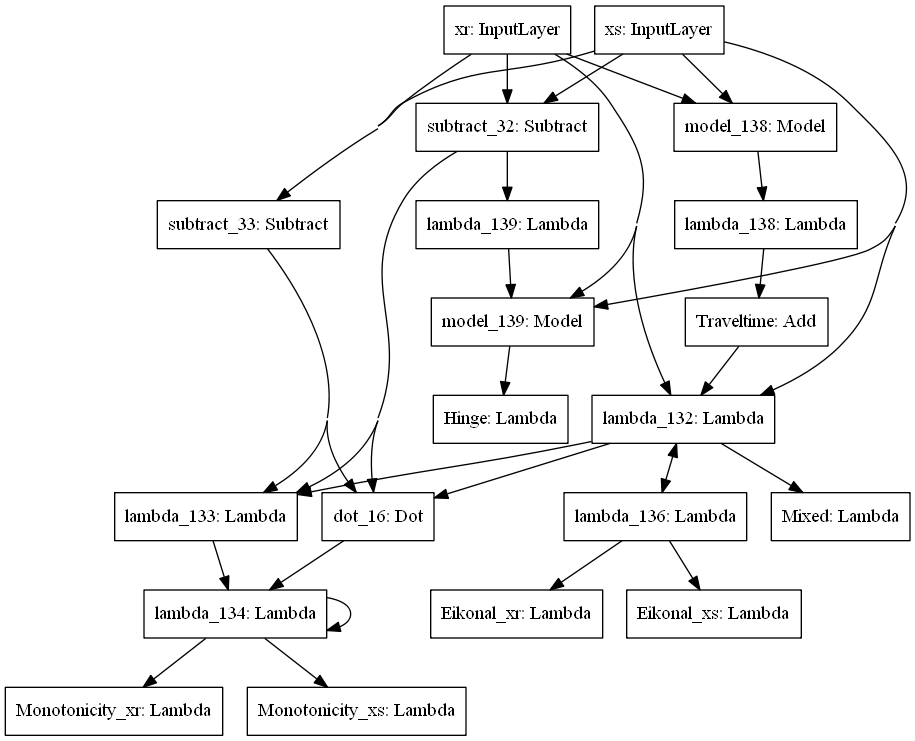

In [131]:
tf.keras.utils.plot_model(model)

In [85]:
T_pred = outs['T'].predict_on_batch(x_test)
M_pred = outs['Mr'].predict_on_batch(x_test)
H_pred = outs['H'].predict_on_batch(x_test)
E_pred = outs['Er'].predict_on_batch(x_test)
S_pred = outs['S'].predict_on_batch(x_test)

In [86]:
T_pred = T_pred.reshape(nx, nx)
M_pred = M_pred.reshape(nx, nx)
H_pred = H_pred.reshape(nx, nx)
E_pred = E_pred.reshape(nx, nx)
S_pred = S_pred.reshape(nx, nx)

In [87]:
S_pred[w==0] = 0.0

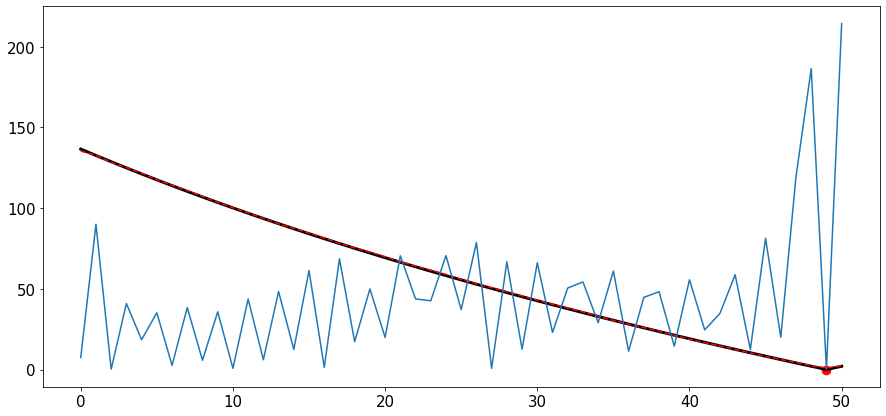

In [88]:
i = 49
plt.figure(figsize=(15,7))
plt.plot(T[i, :], 'k', lw=3)
plt.plot(T_pred[i, :], '--r', lw=1.5)
# plt.plot(M_pred[i, :])
plt.plot(S_pred[i, :]*5e2)
plt.scatter(i, 0, marker='o', c='r', s=75)
plt.show()

In [93]:
V_pred = 1 / E_pred
V_pred[ids==False] = 0.0
np.abs(V_pred[ids] - Vxr[ids]).mean() / Vxr[ids].mean() * 100

2.749813198762782

In [95]:
np.abs(T_pred - T).mean() / T.mean() * 100

0.9368006086878676

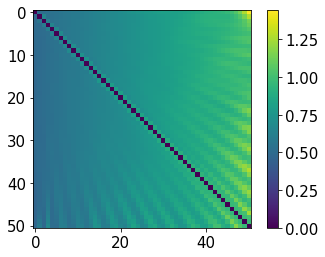

In [96]:
plt.imshow(V_pred)
plt.colorbar()

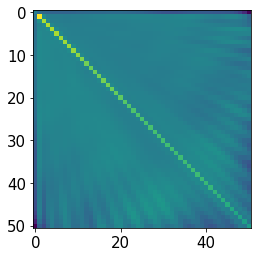

In [97]:
plt.imshow(T_pred - T)

# 2D case

In [3]:
import sys
sys.path.append('../../')
import src.eikonal.helpers as h
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

Using TensorFlow backend.


In [167]:
nr = 41
dim = 2
xmin, xmax = 0.0, 1.0
zmin, zmax = xmin, xmax
xr = np.linspace(xmin, xmax, nr)
zr = xr.copy()
Xr = np.stack(np.meshgrid(xr, zr, indexing='ij'), axis=-1).reshape(-1, dim)

# xs = np.linspace(xmin, xmax, ns)
xs = xr[::8]
ns = len(xs)
zs = xs.copy()
Xs = np.stack(np.meshgrid(xs, zs, indexing='ij'), axis=-1).reshape(-1, dim)

In [168]:
R = cdist(Xs, Xr)
ids = (R > 0).ravel()
XS = np.repeat(Xs[:,None,:], nr*nr, axis=1).reshape(-1, 2)
XR = np.repeat(Xr[None,...], ns*ns, axis=0).reshape(-1, 2)

# x_train = dict(xs = XS[ids][:,0], ys = XS[ids][:,1],
#                xr = XR[ids][:,0], yr = XR[ids][:,1])
# x_test = dict(xs = XS[:,0], ys = XS[:,1],
#               xr = XR[:,0], yr = XR[:,1])

x_train = dict(xs = XS[ids], xr = XR[ids])
x_test = dict(xs = XS, xr = XR)

In [169]:
vmin, vmax = 1.0, 4.0
a = (vmax - vmin) / xmax

Vxr = h.vel_func(vmin, a)(Xr[:,-1])
Vxr_tr = np.repeat(Vxr[None,...], ns*ns, axis=0).ravel()[ids]

Vxs = h.vel_func(vmin, a)(Xs[:,-1])
Vxs_tr = np.repeat(Vxs[..., None], nr*nr, axis=1).ravel()[ids]

In [170]:
Time = np.empty((ns*ns, nr*nr))
for i in tqdm(range(ns*ns)):
    Time[i] = h.t_vgrad(*Xr.T, *Xs[i], vmin, a)

In [260]:
model, outs = NNEikonal(act='tanh', dim=2, factored=True,
                        outputs=['Er', 'Mr', 'H', 'S'])

In [261]:
adam = tf.optimizers.Adam(learning_rate=2.5e-4, decay=5e-3)
model.compile(optimizer=adam, loss='mae', 
#               loss_weights=[1.0, 0.5, 1e3, 1e3, 1.0, 1e-1]
             )

In [262]:
h = model.fit(x=x_train, y=[1/Vxr_tr]+[np.zeros_like(Vxr_tr)]*3, 
              batch_size=800, 
              epochs=10000,
              sample_weight=None,
              verbose=1)

Epoch 1/10000
76/76 [==============================] - 5s 66ms/step - loss: 0.5135 - Eikonal_xr_loss: 0.4405 - Monotonicity_xr_loss: 0.0631 - Hinge_loss: 0.0012 - Mixed_loss: 0.0088
Epoch 2/10000
76/76 [==============================] - 4s 54ms/step - loss: 0.4476 - Eikonal_xr_loss: 0.4322 - Monotonicity_xr_loss: 4.3504e-04 - Hinge_loss: 0.0016 - Mixed_loss: 0.0134
Epoch 3/10000
76/76 [==============================] - 4s 57ms/step - loss: 0.4476 - Eikonal_xr_loss: 0.4321 - Monotonicity_xr_loss: 4.2543e-04 - Hinge_loss: 0.0016 - Mixed_loss: 0.0135
Epoch 4/10000
76/76 [==============================] - 6s 81ms/step - loss: 0.4474 - Eikonal_xr_loss: 0.4320 - Monotonicity_xr_loss: 2.9024e-04 - Hinge_loss: 0.0016 - Mixed_loss: 0.0135
Epoch 5/10000
23/76 [========>.....................] - ETA: 4s - loss: 0.4485 - Eikonal_xr_loss: 0.4327 - Monotonicity_xr_loss: 4.8381e-04 - Hinge_loss: 0.0016 - Mixed_loss: 0.0138

KeyboardInterrupt: 

In [257]:
T_pred = outs['T'].predict_on_batch(x_test).reshape(ns*ns, nr*nr)
E_pred = outs['Er'].predict_on_batch(x_test).reshape(ns*ns, nr*nr)
# M_pred = outs['Mr'].predict_on_batch(x_test).reshape(ns*ns, nr*nr)
# H_pred = outs['H'].predict_on_batch(x_test).reshape(ns*ns, nr*nr)
G = outs['Gr'].predict_on_batch(x_test).reshape(ns*ns, nr*nr, 2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


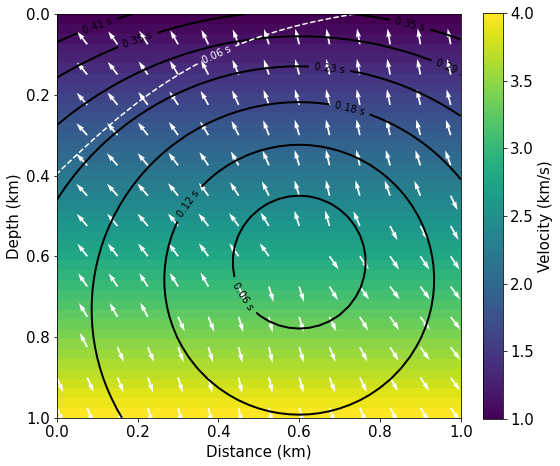

In [258]:
i = 21
T = Time[i].reshape(nr,nr)
T_pr = T_pred[i].reshape(nr,nr)
V = V.reshape(nr,nr)
st = 3
Gr = G[i].T.reshape(2,nr,nr)[:, ::st, ::st]
Gr /= np.linalg.norm(Gr, axis=0)
X = Xr.T.reshape(2,nr,nr)[:, ::st, ::st]

extent1 = np.array((xmin, xmax, zmax, zmin))
extent2 = np.array((xmin, xmax, zmin, zmax))

plt.rcParams['font.size'] = 15

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

im = ax.imshow(V.T, extent=extent1)
plt.quiver(*X, *Gr, units='xy', angles='xy', scale_units='xy', color='white')
# levels = np.linspace(0, T.max(), 9)
levels = np.linspace(0, T.max(), 9)

ctr1 = ax.contour(T.T, levels=levels, colors='k', linestyles='-', linewidths=2, extent=extent2)
ctr2 = ax.contour(T_pr.T, levels=levels, colors='w', linestyles='--', linewidths=1.5, extent=extent2)
plt.clabel(ctr1, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.clabel(ctr2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)

# ax.scatter(ixs * dx / 1000, izs * dz / 1000, marker='.', s=250, color='k')
# ax.scatter(rest_sid[0] * dx / 1000, rest_sid[1] * dz / 1000, marker='.', s=100, color='w')

# ax.scatter(X[bounds[0]] / 1000, X[bounds[1]] / 1000, marker='s', s=70, color='r')

plt.axis('scaled')
# plt.ylim([zmax, zmin])
plt.colorbar(mappable=im, ax=ax, fraction=1/22, label='Velocity (km/s)')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
# ax.set_xticks(np.linspace(0, 2, 5))
# ax.set_yticks(np.linspace(0, 2, 5))

plt.show()

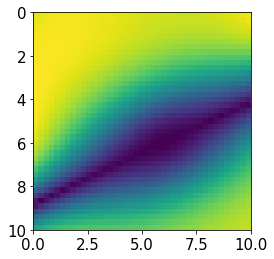

In [259]:
plt.imshow(E_pred[i].reshape(nr, nr).T, extent=(0, 10, 10, 0))